In [ ]:
!nvidia-smi

Mon Nov 28 01:18:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Library

Access to Google Drive folder

In [ ]:
# import requirements
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Useful library

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import random

from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#Constants

In [ ]:
ID_EXERCISE_LABEL = -3
ID_CLUSTER_LABEL = -2
ID_SUBJECT_LABEL = -1

NORM_SAMPLE_LENGTH      = 100
CONSIDERED_SEGMENT      = ['LeftShank', 'RightShank', 'LeftThigh', 'RightThigh', 'Pelvis', 'LeftFoot', 'RightFoot'] # 7 lower limb segments
# NOT_CONSIDERED_INFO     = ['CoMPosition'] # Mocap info: COMPosition and Orientation
NOT_CONSIDERED_INFO     = [''] # Mocap info: COMPosition and Orientation
# NUM_SEGMENT_INFO        = 1 # only orientation (2 if considering both COM position and orientation)
NUM_SEGMENT_INFO        = 2 # both COM position and orientation
NUM_AX_PER_SEGMENT_INFO = 3 # x-, y-, and z-

NUM_SUBJECT             = 20 # will remove the 1st subject later due to IMU data

In [ ]:
# Cluster from the clustering analysis
CLUSTER = [[0, 3, 6, 7, 24, 27, 28, 29, 30, 35],  # cluster 0
           [13, 14, 15, 16, 25],                  # cluster 1
           [12, 17, 20, 31, 32, 33, 34, 36],      # cluster 2
           [22],                                  # cluster 3
           [18, 19, 23, 26],                      # cluster 4
           [21],                                  # cluster 5
           [10, 11],                              # cluster 6
           [8, 9],                                # cluster 7
           [4, 5],                                # cluster 8
           [1, 2]]                                # cluster 9

In [ ]:
# --- Model hyper-parameters --- #
# Fixed parameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 30
ADAM_WEIGHT_DECAY = 1e-2
LEARNING_RATE_REDUCTION_FACTOR = 0.5

# CONV_NUM_IN = 60 # temporarily hardcoded
num_segment = len(CONSIDERED_SEGMENT)
conv_num_in = num_segment*NUM_SEGMENT_INFO*NUM_AX_PER_SEGMENT_INFO

# # Recorded tuning parameters
# # For all 10 IMUs
# # format: [batch_size, conv_num_out, kernel_size, stride_length, pool_size]
# print('Only Orientation')
# TUNED_HP = [[0, 0, 0, 0, 0],      # subject 1 <--- removed due to only 5 IMUs
#             [32, 256, 4, 1, 2],   # subject 2 left for testing
#             [32, 128, 4, 1, 2],   # subject 3 left for testing
#             [32, 256, 4, 1, 2],   # subject 4 left for testing
#             [16, 256, 4, 1, 2],   # subject 5 left for testing
#             [32, 128, 4, 1, 2],   # subject 6 left for testing
#             [64, 256, 4, 1, 2],   # subject 7 left for testing
#             [16, 256, 4, 1, 2],   # subject 8 left for testing
#             [64, 128, 4, 1, 2],   # subject 9 left for testing
#             [32, 128, 4, 1, 2],   # subject 10 left for testing
#             [16, 256, 4, 1, 2],   # subject 11 left for testing
#             [32, 256, 4, 1, 2],   # subject 12 left for testing
#             [128, 128, 4, 1, 2],   # subject 14 left for testing
#             [64, 256, 4, 1, 2],   # subject 15 left for testing
#             [32, 256, 4, 1, 2],   # subject 16 left for testing
#             [32, 256, 4, 1, 2],  # subject 17 left for testing
#             [16, 256, 4, 1, 2],   # subject 18 left for testing
#             [32, 256, 4, 1, 2],   # subject 19 left for testing
#             [16, 256, 4, 1, 2],   # subject 21 left for testing
#             [32, 256, 4, 1, 2]]   # subject 22 left for testing

# Right wrist
print('Including CoMPosition')
TUNED_HP = [[0, 0, 0, 0, 0],      # subject 1 <--- removed due to only 5 IMUs
            [64, 256, 4, 1, 2],   # subject 2 left for testing
            [64, 256, 4, 1, 2],   # subject 3 left for testing
            [32, 256, 4, 1, 2],   # subject 4 left for testing
            [128, 256, 4, 1, 2],   # subject 5 left for testing
            [64, 256, 4, 1, 2],   # subject 6 left for testing
            [64, 256, 4, 1, 2],   # subject 7 left for testing
            [128, 256, 4, 1, 2],   # subject 8 left for testing
            [32, 256, 4, 1, 2],   # subject 9 left for testing
            [128, 256, 4, 1, 2],   # subject 10 left for testing
            [128, 256, 4, 1, 2],   # subject 11 left for testing
            [32, 256, 4, 1, 2],   # subject 12 left for testing
            [32, 128, 4, 1, 2],   # subject 14 left for testing
            [32, 128, 4, 1, 2],   # subject 15 left for testing
            [128, 256, 4, 1, 2],   # subject 16 left for testing
            [32, 256, 4, 1, 2],  # subject 17 left for testing
            [16, 256, 4, 1, 2],   # subject 18 left for testing
            [32, 256, 4, 1, 2],   # subject 19 left for testing
            [32, 256, 4, 1, 2],   # subject 21 left for testing
            [64, 256, 4, 1, 2]]   # subject 22 left for testing

# Id for tuning parameters
ID_BATCH_SIZE = 0
ID_NUM_OUT = 1
ID_KERNEL_SIZE = 2
ID_STRIDE = 3
ID_POOL_SIZE = 4

Including CoMPosition


#Utils

Pre-processing

In [ ]:
# all helper function here
# helper functions
def mkfolder(pth):
  if not os.path.exists(pth):
    os.mkdir(pth)

def read(pth):
  return pd.read_csv(pth)

# Load and re-format the data file
def load_df(pth):
  dtframe = read(pth)
  dtframe = dtframe.iloc[:, 1:] # remove the first 3 columns

  # Re-formatting the column's names
  # e.g., Pevist Accelerometer X, LeftFoot Gyroscope Z, etc.
  names = list(dtframe.columns)
  names = [name.split('.')[0] for name in names]
  names_2 = dtframe.iloc[0, :]
  names_3 = dtframe.iloc[1, :]

  for i in range(len(names)):
    names[i] = names[i]+' '+names_2[i]+' '+names_3[i]

  dtframe = dtframe.iloc[2:, :] # remove the first 2 rows
  dtframe.columns = names # update new column's names

  return dtframe

def slice_df(dtframe):
  cols = sorted(dtframe.columns)

  req_cols = [col for col in cols if col.split(' ')[0] in CONSIDERED_SEGMENT] # only keep data from considered sensors (may not be all 10), e.g., chest, pelvis, etc.
  req_cols = [col for col in req_cols if col.split(' ')[1] not in NOT_CONSIDERED_INFO] # not use information from orientation, magnetometer or time

  dtframe = dtframe.loc[:, req_cols]

  return dtframe

# One hot encoding
def one_hot_encoding(label, num_clasess):
  temp = np.zeros(num_clasess)
  temp[label] = 1

  return temp

# One hot decoding
def one_hot_decoding(num):
  if num.shape[0] > 0:
    temp = np.array([np.where(row == 1) for row in num])
  else:
    temp = np.argwhere(num == 1)

  return temp

# Normalize data to have the same sample length for training the network
def normLength(arr, maxlength):
  new_arr = np.zeros((maxlength, arr.shape[-1]))
  for i in range(arr.shape[-1]):
    a = arr[:, i]
    k = a.shape[0]
    y = np.interp(np.linspace(0, 1, maxlength), np.linspace(0, 1, k), a)
    new_arr[:, i] = y
  return new_arr

# Obtain cluster label from the previous clustering analysis
def get_cluster_label(ex_code):
  cluster_found = False
  cluster_id = 0

  while not cluster_found:
    if ex_code in CLUSTER[cluster_id]:
      cluster_found = True
    else:
      cluster_id += 1 # increase the id

  return cluster_id

Dataset handler

In [ ]:
class MyDataset(Dataset):
    def __init__(self, list_of_samples, to_size, num_classes):
      self.to_size = to_size

      list_of_samples = [normLength(sample, NORM_SAMPLE_LENGTH).T for sample in list_of_samples]

      self.X = [sample[:ID_EXERCISE_LABEL, :] for sample in list_of_samples] # <-- take only 60 columns of data
      
      if num_classes < 37:
        self.Y = [one_hot_encoding(int(sample[ID_CLUSTER_LABEL, :][0]), num_classes) for sample in list_of_samples]
      else:
        self.Y = [one_hot_encoding(int(sample[ID_EXERCISE_LABEL, :][0]), num_classes) for sample in list_of_samples]

    def __len__(self):
      return len(self.Y)

    def __getitem__(self, idx):
      x = torch.from_numpy(self.X[idx]).float()
      y = self.Y[idx]
      # y = int(self.Y[0])
      # y = np.array(y)
      if device == 'cuda':
        x = x.to(device)
        y = torch.from_numpy(y)
        y = y.to(device)
      return x, y

Model

In [ ]:
class CNN_Alter_Block(nn.Module):
    def __init__(self, num_in, num_out, kernel_size, stride, pool_size, num_classes):
        super(CNN_Alter_Block, self).__init__()
        self.conv1    = nn.Conv1d(num_in, num_out, kernel_size, stride)      # input paramters
        self.relu1    = nn.ReLU()
        self.bnorm    = nn.BatchNorm1d(num_out)
        self.pooling  = nn.MaxPool1d((pool_size))

        self.flatten  = nn.Flatten()
        self.dropout  = nn.Dropout(p = 0.5)
        self.fcl      = nn.LazyLinear(out_features = num_classes)
        self.sfmx     = nn.Softmax(dim=1)

    def forward(self, x):
        # x = x.cuda()
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bnorm(x)
        x = self.pooling(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fcl(x)
        x = self.sfmx(x)
        return x

Evaluate prediction

In [ ]:
# ---> Remember to check one more time before running the loop
def predict(some_tensor, labs, num_classes):
  some_tensor = some_tensor.cpu().detach().numpy()
  labs        = labs.cpu().detach().numpy()

  cm = np.zeros([num_classes, num_classes]) # for storing confusion matrix

  y_truth = []
  y_pred = []

  count = 0 # for average accuracy

  for i in range(some_tensor.shape[0]):
    temp_pred = np.argmax(some_tensor[i])
    temp_truth = np.argmax(labs[i])

    # Update confusion matrix
    cm[temp_truth, temp_pred] = cm[temp_truth, temp_pred] + 1

    # print('Prediction = ' + str(temp_pred) + ' - ' + 'Truth = ' + str(temp_truth))

    # Add truth and pred. values
    y_truth.append(temp_truth)
    y_pred.append(temp_pred)

    # Update accuracy
    if temp_pred == temp_truth:
      count = count + 1
    else:
      pass # do nothing
  
  return count, cm, y_truth, y_pred

Model loop

In [ ]:
val_acc, best_val_loss = 0, 1.0

# --- Training --- #
def train_loop(dataloader, model, loss_fn, optimizer, num_classes):
    global train_mode
    train_mode = True

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct, sched_factor = 0, 0, 0

    cm = np.zeros([num_classes, num_classes]) # for storing confusion matrix

    y_truth = []
    y_pred = []

    for batch, (X, y) in enumerate(dataloader):
        # print(X)
        # Compute prediction and loss
        pred = model(X)
        # print(pred)
        # print(predict(pred, y))
        # print('----------------------')
        # print(pred)
        # print(y)
        # break
        y = y.type(torch.FloatTensor)
        if device == 'cuda': y = y.cuda()

        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        temp_correct, temp_cm, temp_y_truth, temp_y_pred = predict(pred, y, num_classes)
        correct = correct + temp_correct 
        cm = cm + temp_cm
        y_truth = y_truth + temp_y_truth
        y_pred = y_pred + temp_y_pred
        train_loss  += loss_fn(pred, y).item()

    train_loss /= num_batches
    train_losses.append(train_loss)
    correct /= size

    scheduler.step(train_loss)

    # print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

    return correct, cm, y_truth, y_pred

# --- Testing --- #
def test_loop(dataloader, model, loss_fn, num_classes):
    global train_mode
    train_mode = False

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct, size = 0, 0, 0

    cm = np.zeros([num_classes, num_classes]) # for storing confusion matrix

    y_truth = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            # pred = predict(pred, y)
            y = y.type(torch.FloatTensor)
            if device == 'cuda': y = y.cuda()
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item() # comment out

            temp_correct, temp_cm, temp_y_truth, temp_y_pred = predict(pred, y, num_classes)
            correct = correct + temp_correct
            cm = cm + temp_cm
            y_truth = y_truth + temp_y_truth
            y_pred = y_pred + temp_y_pred
            size    += y.shape[0]

    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return correct, cm, y_truth, y_pred

LOSOCV

In [ ]:
def losocv_split_train_list(all_subject_id, test_subject):  
  train_list = [m for m in all_subject_id if m != test_subject]

  return train_list

#Subjects and Exercises

In [ ]:
# THIS IS WHEN USING COLAB GPU <------------------- NOTICE
root_path = 'drive/MyDrive/mbl/parsed_MoCap_kinematics/'
subs = sorted(list(os.listdir(root_path)))
# subs = subs[:-1] # remove 'merged' # we don't have 'merged' in this folder

In [ ]:
# total should be 20
num_subject = len(subs)
num_subject

20

Obtain exercises

In [ ]:
exercises = [sorted(os.listdir(root_path+sub)) for sub in subs]

# Get types of exercises (i.e., physical activities)
exercise_types = []
for ex in exercises:
  exercise_types.extend(ex)

In [ ]:
for ex in exercises:
  print(len(ex), ex)

14 ['CMJDL', 'DropJumpDL', 'DropLandDL', 'HeelRaise', 'Lunge', 'MaxJump', 'Run', 'SqDL', 'SqHalfDL', 'StepDnH', 'StepDnL', 'StepUpH', 'StepUpL', 'Walk']
37 ['BulgSq', 'CMJDL', 'CMJSL', 'DeclineSq', 'DropJumpDL', 'DropJumpSL', 'DropLandDL', 'DropLandSL', 'FwHop', 'FwHopFast', 'FwJump', 'FwJumpFast', 'HeelRaise', 'LatHop', 'LatHopFast', 'LatJump', 'LatJumpFast', 'Lunge', 'MaxHop', 'MaxJump', 'Pose', 'Run', 'RunCut', 'RunDec', 'SpainSq', 'SplitJump', 'SportJump', 'SqDL', 'SqHalfDL', 'SqHalfSL', 'SqSL', 'StepDnH', 'StepDnL', 'StepUpH', 'StepUpL', 'SumoSq', 'Walk']
37 ['BulgSq', 'CMJDL', 'CMJSL', 'DeclineSq', 'DropJumpDL', 'DropJumpSL', 'DropLandDL', 'DropLandSL', 'FwHop', 'FwHopFast', 'FwJump', 'FwJumpFast', 'HeelRaise', 'LatHop', 'LatHopFast', 'LatJump', 'LatJumpFast', 'Lunge', 'MaxHop', 'MaxJump', 'Pose', 'Run', 'RunCut', 'RunDec', 'SpainSq', 'SplitJump', 'SportJump', 'SqDL', 'SqHalfDL', 'SqHalfSL', 'SqSL', 'StepDnH', 'StepDnL', 'StepUpH', 'StepUpL', 'SumoSq', 'Walk']
37 ['BulgSq', 'CMJD

In [ ]:
exercise_types = np.array(exercise_types)
exercise_types, _ = np.unique(exercise_types, return_index=True)
exercise_types = exercise_types.tolist()
exercise_types

['BulgSq',
 'CMJDL',
 'CMJSL',
 'DeclineSq',
 'DropJumpDL',
 'DropJumpSL',
 'DropLandDL',
 'DropLandSL',
 'FwHop',
 'FwHopFast',
 'FwJump',
 'FwJumpFast',
 'HeelRaise',
 'LatHop',
 'LatHopFast',
 'LatJump',
 'LatJumpFast',
 'Lunge',
 'MaxHop',
 'MaxJump',
 'Pose',
 'Run',
 'RunCut',
 'RunDec',
 'SpainSq',
 'SplitJump',
 'SportJump',
 'SqDL',
 'SqHalfDL',
 'SqHalfSL',
 'SqSL',
 'StepDnH',
 'StepDnL',
 'StepUpH',
 'StepUpL',
 'SumoSq',
 'Walk']

In [ ]:
# total should be 37
num_exercise = len(exercise_types)
num_exercise

37

Label clusters

In [ ]:
num_clusters = len(CLUSTER)
num_clusters

10

Label exercises

In [ ]:
exercise_code = list(range(0, num_exercise))
label_code = dict(zip(exercise_types, exercise_code))
code_label = dict(zip(exercise_code, exercise_types))

Label subjects

In [ ]:
subs_code = list(range(0, num_subject))
subject_code = dict(zip(subs, subs_code))
code_subject = dict(zip(subs_code, subs))

#Collect Data Samples

In [ ]:
sample_list, file_paths = [], []

num_missing_dt = 0 # count number of files with missing data to remove them out
num_col_in_dt = num_segment*NUM_SEGMENT_INFO*NUM_AX_PER_SEGMENT_INFO + 3 # exercise label + cluster label + subject label

print("Number of columns that should be in the dataframe = " + str(num_col_in_dt))

no_of_samples = None

# Loop through subjects (removed the first subject due to only 5 IMUs)
for subject in tqdm(subs[1:]): 
  print()
  print('Collecting data from subject ' + str(subject) + ' ...')

  for ex in exercise_types:
    # If the subject perform the task
    try:
      folder_path = root_path + subject + '/' + ex + '/'
      file_names = os.listdir(folder_path) # obtain all parsed data files
      no_of_samples = len(file_names) # to display the no. of samples lately

      for file_name in file_names:
        sample_path = folder_path + file_name
        df = load_df(sample_path) # load and re-format the data file
        df = slice_df(df) # pick data from considered sensors and remove unnecessary information
        df['target'] = label_code[ex] # add output for the data file (i.e., exercise label)
        df['cluster'] = get_cluster_label(label_code[ex]) # i.e., cluster label
        df['subject_id'] = subject_code[subject] # add subject id for the data (i.e., subject label)

        sample_arr = np.array(df).astype(float) # convert to numpy array type

        # Check if the data has all considered parts
        if sample_arr.shape[1] != num_col_in_dt:
          num_missing_dt += 1
        else:
          sample_list.append(sample_arr)

        # break
      # print('\n' + str(no_of_samples) + ' samples collected from ' + ex)
      
    except:
      # print('\n' + ex + ' was missing')
      pass # do nothing

  print() # TBD

Number of columns that should be in the dataframe = 45


  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:01<00:25,  1.40s/it]

 11%|█         | 2/19 [00:02<00:25,  1.49s/it]

 16%|█▌        | 3/19 [00:04<00:23,  1.49s/it]

 21%|██        | 4/19 [00:05<00:22,  1.48s/it]

 26%|██▋       | 5/19 [00:07<00:20,  1.48s/it]

 32%|███▏      | 6/19 [00:08<00:19,  1.50s/it]

 37%|███▋      | 7/19 [00:10<00:18,  1.52s/it]

 42%|████▏     | 8/19 [00:11<00:16,  1.50s/it]

 47%|████▋     | 9/19 [00:13<00:14,  1.47s/it]

 53%|█████▎    | 10/19 [00:14<00:13,  1.48s/it]

 58%|█████▊    | 11/19 [00:16<00:11,  1.48s/it]

 63%|██████▎   | 12/19 [00:17<00:10,  1.48s/it]

 68%|██████▊   | 13/19 [00:19<00:09,  1.51s/it]

 74%|███████▎  | 14/19 [00:20<00:07,  1.50s/it]

 79%|███████▉  | 15/19 [00:22<00:06,  1.58s/it]

 84%|████████▍ | 16/19 [00:24<00:04,  1.65s/it]

 89%|████████▉ | 17/19 [00:26<00:03,  1.63s/it]

 95%|█████████▍| 18/19 [00:27<00:01,  1.65s/it]

100%|██████████| 19/19 [00:29<00:00,  1.54s/it]

In [ ]:
len(sample_list)

3211

#The Loop

Check device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Performance evaluation *(with tuned hyper-parameters recorded from the tuning)*

In [ ]:
# Removed subject 1 due to missing IMUs
all_subject_id = list(range(1, NUM_SUBJECT))

# Training/testing accuracy of performance evaluation
perf_train_acc = []
perf_test_acc = []

# Training/testing confusion matrices
perf_train_cm = []
perf_test_cm = []

# Testing prediction performance
perf_test_y_pred = []
perf_test_y_truth = []

# Performance evaluation
# for test_subject in all_subject_id[0:1]: # for testing purpose
for test_subject in all_subject_id[:]:
  print('# Working on test subject ' + str(test_subject))

  # --- Divide training/testing data according to LOSOCV --- #
  train_list, test_list = [], []

  for sample in sample_list:    
    if sample[0, ID_SUBJECT_LABEL] != test_subject: # data not from the testing subject
      train_list.append(sample) 
    else: # data from the testing subject
      test_list.append(sample)  
  
  # --- Obtain hyper-parameters from the pre-tuning process --- #
  print('--- Obtain hyper-parameters')
  hp_point = TUNED_HP[test_subject] # get the set of tune hyper-parameters
  s_batch_size  = hp_point[ID_BATCH_SIZE]
  s_num_out     = hp_point[ID_NUM_OUT]
  s_kernel_size = hp_point[ID_KERNEL_SIZE]
  s_stride      = hp_point[ID_STRIDE] 
  s_pool_size   = hp_point[ID_POOL_SIZE]

  print(' + batch size = ' + str(s_batch_size))
  print(' + conv. num. out = ' + str(s_num_out))
  print(' + kernel size = ' + str(s_kernel_size))
  print(' + stride length = ' + str(s_stride))
  print(' + pool size = ' + str(s_pool_size))

  # --- Make dataset --- #
  # Normalize
  train_data  = MyDataset(train_list, NORM_SAMPLE_LENGTH, num_clusters) # <-- Here to modify the number of classes (i.e., num_clusters or num_exercise)
  test_data   = MyDataset(test_list, NORM_SAMPLE_LENGTH, num_clusters) # <-- Here to modify the number of classes (i.e., num_clusters or num_exercise)

  # Wrap dataloader   
  train_dataloader  = DataLoader(train_data, batch_size = s_batch_size, shuffle=True)
  test_dataloader   = DataLoader(test_data, batch_size  = s_batch_size, shuffle=False)

  # --- Model and training --- #
  # Model
  # model = CNN_One_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Two_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Three_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_One_Deep_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Two_Deep_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Parallel_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  model = CNN_Alter_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size, num_clusters) # <-- Here to modify the number of classes (i.e., num_clusters or num_exercise)
  if device == 'cuda': model = model.cuda()

  # for plotting
  train_losses, val_losses = [], []

  # Initialize the loss function
  loss_fn = nn.CrossEntropyLoss()

  # Initialize the optimisation function
  optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = ADAM_WEIGHT_DECAY)

  # Scheduler
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = LEARNING_RATE_REDUCTION_FACTOR)

  print('--- Start the performance evaluation')
  for t in range(NUM_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    temp_train_acc, temp_train_cm, _, _  = train_loop(train_dataloader, model, loss_fn, optimizer, num_clusters) # <-- Here to modify the number of classes (i.e., num_clusters or num_exercise)
    temp_test_acc, temp_test_cm, temp_y_truth, temp_y_pred   = test_loop(test_dataloader, model, loss_fn, num_clusters) # <-- Here to modify the number of classes (i.e., num_clusters or num_exercise)

  # Store the training/testing performance
  print('*** Training/testing performance')
  perf_train_acc.append(temp_train_acc)
  perf_test_acc.append(temp_test_acc)
  print(perf_train_acc)
  print(perf_test_acc)

  # Store the confusion matrices
  print('*** Confusion matrix')  
  perf_train_cm.append(temp_train_cm)
  perf_test_cm.append(temp_test_cm)
  print('Not displayed but added')
  # print(perf_train_cm)
  # print(perf_test_cm)

  perf_test_y_truth.append(temp_y_truth)
  perf_test_y_pred.append(temp_y_pred)


# Working on test subject 1
--- Obtain hyper-parameters
 + batch size = 64
 + conv. num. out = 256
 + kernel size = 4
 + stride length = 1
 + pool size = 2


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


--- Start the performance evaluation
Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
Epoch 21
-------------------------------
Epoch 22
-------------------------------
Epoch 23
-------------------------------
Epoch 24
--------------------

Monitor the performance

In [ ]:
# Compute the average training/testing accuracy
avg_train_acc = round((sum(perf_train_acc)*100.0/len(perf_train_acc)), 4)
avg_test_acc = round((sum(perf_test_acc)*100.0/len(perf_test_acc)), 4)

print('Average training accuracy = ' + str(avg_train_acc))
print('Average testing accuracy = ' + str(avg_test_acc))

Average training accuracy = 95.3867
Average testing accuracy = 90.9554


In [ ]:
# Plot confusion matrices
import seaborn as sns 

verf_count = 0

for i in range(len(perf_test_cm)):
  # plt.figure(i)
  # sns.heatmap(perf_test_cm[i], cmap = 'YlGnBu')
  # plt.title('No. samples = ' + str(np.sum(perf_test_cm[i])) + '\n' + '(Testing) accuracy = ' + str(perf_test_acc[i]))
  # plt.xlabel('Prediction')
  # plt.ylabel('Truth')

  verf_count = verf_count + np.sum(perf_test_cm[i])

print('Would be wrong if verf_count is not the total number of samples in the dataset, i.e., 3212')
print(verf_count)

Would be wrong if verf_count is not the total number of samples in the dataset, i.e., 3212
3211.0


Store results for later processing

In [ ]:
# Store accuracy
with open('train_acc.npy', 'wb') as f:
  np.save(f, np.array(perf_train_acc))
with open('test_acc.npy', 'wb') as f:
  np.save(f, np.array(perf_test_acc))

# Store confusion matrices
with open('train_cm.npy', 'wb') as f:
  np.save(f, np.array(perf_train_cm))
with open('test_cm.npy', 'wb') as f:
  np.save(f, np.array(perf_test_cm))

# Store truth and pred values of the testing set
with open('test_y_truth.npy', 'wb') as f:
  np.save(f, np.array(perf_test_y_truth))
with open('test_y_pred.npy', 'wb') as f:
  np.save(f, np.array(perf_test_y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#Post-processing Results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics

Read data

In [ ]:
# Retrieve accuracy
with open('train_acc.npy', 'rb') as f:
  r_train_acc = np.load(f)
with open('test_acc.npy', 'rb') as f:
  r_test_acc = np.load(f)

# Retrieve confusion matrices
with open('train_cm.npy', 'rb') as f:
  r_train_cm = np.load(f)
with open('test_cm.npy', 'rb') as f:
  r_test_cm = np.load(f)

# Retrieve y truth and pred
with open('test_y_truth.npy', 'rb') as f:
  r_y_truth = np.load(f, allow_pickle = True)
with open('test_y_pred.npy', 'rb') as f:
  r_y_pred = np.load(f, allow_pickle = True)

In [ ]:
len(perf_test_y_truth[0])

148

148.0


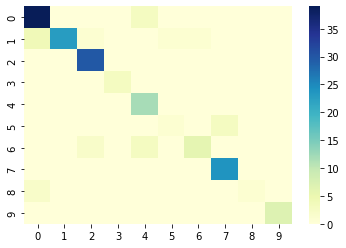

In [ ]:
plt.figure
sns.heatmap(r_test_cm[9], cmap = 'YlGnBu')
print(np.sum(r_test_cm[0]))

In [ ]:
r_train_cm[0][1, :].shape

(37,)

In [ ]:
r_test_cm.shape

(19, 10, 10)

In [ ]:
# Normalize confusion matrix
def normalize_cm(cm):
  norm_cm = np.zeros(cm.shape) # init

  num_sbj = cm.shape[0]
  num_ex = cm.shape[1]

  # Loop through subject with different confusion matrices
  for s in range(num_sbj):

    # Loop through exercises
    for e in range(num_ex):

      # Check if there is missing exercise
      num_trial = sum(cm[s][e, :])

      if num_trial != 0:
        norm_cm[s][e, :] = cm[s][e, :]/num_trial
      else:
        pass # do nothing since the row is already zero

  return norm_cm

# Average the normalize confusion matrix
def get_avg_cm(norm_cm):
  num_sbj = norm_cm.shape[0]
  num_ex = norm_cm.shape[1]

  avg_norm_cm = np.zeros([num_ex, num_ex]) # init
  num_trials = np.zeros(num_ex) # store the no. of trials for each exercise

  # Loop through subjects
  for s in range(num_sbj):
     
     # Loop through exercises
     for e in range(num_ex):

      # Check if there is missing trial
      if sum(norm_cm[s][e, :]) != 0:
        avg_norm_cm[e, :] = avg_norm_cm[e, :] + norm_cm[s][e, :]
        num_trials[e] = num_trials[e] + 1
      else:
        pass

  # Compute the average
  for e in range(num_ex):
    avg_norm_cm[e, :] = avg_norm_cm[e, :]/num_trials[e]

  return avg_norm_cm

# Get precision, recall, and F1-score (averaged across exercises and subjects) from confusion matrices
def get_avg_metrics_from_cm(cm):
  precision_mat = np.zeros([19, 37]) # each row is a subject, each column is an exercise
  recall_mat = np.zeros([19, 37])
  f1_score_mat = np.zeros([19, 37])

  num_sbj = cm.shape[0]
  num_ex = cm.shape[1]

  for s in range(num_sbj):

    for e in range(num_ex):
      
      # Compute precision
      if sum(cm[s][:, e]) != 0:
        temp_precision = cm[s][e, e] / sum(cm[s][:, e])        
      else:
        temp_precision = 0
      precision_mat[s, e] = temp_precision

      # Compute recall
      if sum(cm[s][e, :]) != 0:
        temp_recall = cm[s][e, e] / sum(cm[s][e, :])
      else:
        temp_recall = 0
      recall_mat[s, e] = temp_recall

      # Compute F1-score
      if (temp_precision != 0) and (temp_recall != 0):
        temp_f1 = 2*(temp_recall*temp_precision)/(temp_recall + temp_precision)
      else:
        temp_f1 = 0
      f1_score_mat[s, e] = temp_f1
  
  # Average
  precision = precision_mat.mean()
  recall = recall_mat.mean()
  f1 = f1_score_mat.mean()

  return precision, recall, f1

In [ ]:
norm_train_cm = normalize_cm(r_train_cm)
norm_test_cm = normalize_cm(r_test_cm)

In [ ]:
sbj_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22]

for i in range(len(r_test_cm)):
  plt.figure(i)
  sns.heatmap(r_test_cm[i], cmap = 'YlGnBu')
  plt.title('S' + str(sbj_list[i]) + ' left for testing')
  plt.xlabel('Prediction')
  plt.ylabel('Truth')

In [ ]:
sbj_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22]

for i in range(len(norm_test_cm)):
  plt.figure(i)
  sns.heatmap(norm_test_cm[i], cmap = 'YlGnBu')
  plt.title('S' + str(sbj_list[i]) + ' left for testing')
  plt.xlabel('Prediction')
  plt.ylabel('Truth')

In [ ]:
avg_norm_cm = get_avg_cm(norm_test_cm)

Text(69.0, 0.5, 'Truth')

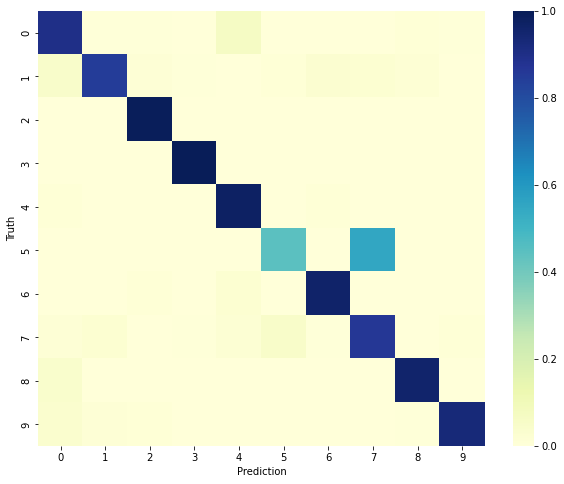

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(avg_norm_cm, cmap = 'YlGnBu')
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [ ]:
pd.DataFrame(r_train_acc)

,0
0,0.969964
1,0.952084
2,0.951115
3,0.952194
4,0.953053
5,0.952053
6,0.969099
7,0.950900
8,0.951914
9,0.924138


In [ ]:
pd.DataFrame(r_test_acc)

,0
0,0.912162
1,0.920732
2,0.883436
3,0.904459
4,0.939394
5,0.933735
6,0.958580
7,0.871795
8,0.954545
9,0.879518


Get precision, recall, and F1-score

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
# Precision
precision_arr = []
for i in range(19):
  precision_arr.append(precision_score(r_y_truth[i], r_y_pred[i], average = 'macro'))

pd.DataFrame(precision_arr)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0
0,0.832440
1,0.829882
2,0.870569
3,0.902679
4,0.946722
5,0.884020
6,0.933647
7,0.825991
8,0.927085
9,0.868846


In [ ]:
# Recall
recall_arr = []
for i in range(19):
  recall_arr.append(recall_score(r_y_truth[i], r_y_pred[i], average = 'macro'))

pd.DataFrame(recall_arr)

,0
0,0.890159
1,0.843333
2,0.878601
3,0.877627
4,0.917639
5,0.886970
6,0.929762
7,0.875460
8,0.912078
9,0.782403


In [ ]:
# F1-score
f1_arr = []

for i in range(19):
  f1_arr.append(f1_score(r_y_truth[i], r_y_pred[i], average = 'macro'))

pd.DataFrame(f1_arr)

,0
0,0.851010
1,0.831688
2,0.838822
3,0.859956
4,0.916397
5,0.875492
6,0.929903
7,0.834785
8,0.914602
9,0.795803
